# Music Similarity Analysis Pipeline

This notebook implements the complete music similarity system with 4 layers:
1. A-Weighted Perceptual Features (Layer 1)
2. Grouped Feature Similarity (Layer 2)
3. UMAP Dimensionality Reduction (Layer 3)
4. Query-by-Humming (Layer 4)

## Setup & Imports

In [7]:
import os
import pandas as pd
import numpy as np
import librosa
import warnings

# Configure pandas to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from utils.similarity import find_similar_layered
from utils.feature_groups import get_feature_groups
from utils.umap_layer import compute_group_umaps
from utils.process_spectrograms import (
    build_qbh_dataset,
    scale_qbh_features,
    extract_qbh_embedding,
    scale_features
)

from utils.similarity import find_similar_qbh
from utils.visualization import plot_waveform, plot_distribution, plot_umap

warnings.filterwarnings("ignore", category=UserWarning)

c:\Users\Korisnik\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Clear any cached modules to ensure fresh imports
# Added to ensure QbH search runs smoothl whenever the query file is changed (in query_path)
import sys
if 'process_spectrograms' in sys.modules:
    del sys.modules['process_spectrograms']
if 'similarity' in sys.modules:
    del sys.modules['similarity']
if 'feature_groups' in sys.modules:
    del sys.modules['feature_groups']
if 'umap_layer' in sys.modules:
    del sys.modules['umap_layer']

print("Caches cleared. Ready for fresh run.")

Caches cleared. Ready for fresh run.


In [9]:
# Define query path at the beginning so it's available everywhere
query_path = "queries/humming2.wav"
print(f"Query file set to: {query_path}")

Query file set to: queries/humming2.wav


## Load Features

In [10]:
df = pd.read_csv("features_full_combined.csv")

df["track_id"] = (
    df["filename"]
    .str.replace(".wav", "", regex=False)
    .str.replace(".", "", regex=False)
)
df["genre"] = df["filename"].str.split(".").str[0]

print(f"Loaded {len(df)} tracks")
print(f"Genres: {df['genre'].unique()}")

Loaded 1000 tracks
Genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


## Layer 1: Scaling

In [11]:
X_scaled = scale_features(df, df[["track_id", "genre"]])
print(f"Scaled features shape: {X_scaled.shape}")
print(f"\nColumns: {list(X_scaled.columns)}")

Scaled features shape: (1000, 84)

Columns: ['track_id', 'genre', 'mfcc9_mean', 'mfcc14_var', 'mfcc7_var', 'mfcc10_mean', 'mfcc6_mean', 'a_weighted_mel1', 'mfcc21_mean', 'zero_crossing_rate_mean', 'a_weighted_mel3', 'a_weighted_mel4', 'mfcc10_var', 'mfcc3_var', 'chroma_stft_mean', 'a_weighted_mel12', 'mfcc15_var', 'a_weighted_mel5', 'mfcc13_var', 'spectral_bandwidth_var', 'a_weighted_mel7', 'mfcc5_var', 'mfcc11_var', 'a_weighted_mel2', 'a_weighted_mel20', 'a_weighted_mel11', 'spectral_centroid_var', 'mfcc20_var', 'mfcc12_var', 'chroma_stft_var', 'a_weighted_mel6', 'mfcc13_mean', 'spectral_bandwidth_mean', 'zero_crossing_rate_var', 'mfcc18_var', 'mfcc1_mean', 'a_weighted_mel9', 'a_weighted_mel19', 'mfcc17_mean', 'mfcc11_mean', 'mfcc18_mean', 'mfcc14_mean', 'mfcc15_mean', 'rolloff_var', 'a_weighted_mel17', 'harmony_var', 'a_weighted_mel13', 'a_weighted_mel15', 'a_weighted_mel22', 'mfcc12_mean', 'spectral_centroid_mean', 'mfcc17_var', 'mfcc6_var', 'percussive_var', 'rms_var', 'a_weighted_

## Layer 2: Grouped Similarity

In [12]:
feature_groups = get_feature_groups(X_scaled)
print("Feature groups:")
for group, cols in feature_groups.items():
    print(f"  {group}: {len(cols)} features")

Feature groups:
  timbre: 46 features
  spectral: 6 features
  rhythm_tempo: 3 features
  chroma_harmony: 6 features
  a_weighted: 22 features


In [20]:
# Select a random track_id
track_id = np.random.choice(X_scaled['track_id'].values)

# Comment this line to keep the search random (metal00027 is described in the seminar paper results)
track_id = 'metal00027'

print(f"Selected track_id for similarity search: {track_id}")

similarity_results = find_similar_layered(
    track_id=track_id,
    X_scaled=X_scaled,
    top_n=5
)

print(f"\nTop 5 similar tracks to {track_id}:")
print(similarity_results)

Selected track_id for similarity search: metal00027

Top 5 similar tracks to metal00027:
         track_id    genre  total_distance  layer1_distance  timbre_distance  \
681    metal00082    metal        1.662031         0.324764         0.976832   
671    metal00072    metal        1.718887         0.220869         0.903371   
986     rock00087     rock        1.743279         0.249365         0.801338   
205  country00005  country        1.753581         0.221060         0.909744   
768      pop00069      pop        1.778250         0.303252         0.943128   

     spectral_distance  rhythm_tempo_distance  chroma_harmony_distance  \
681           0.101657               0.097912                 0.160867   
671           0.080354               0.106788                 0.407504   
986           0.100115               0.002692                 0.589769   
205           0.246817               0.045197                 0.330763   
768           0.143085               0.109367               

## Layer 4: Query-by-Humming

In [ ]:
#if not os.path.exists("qbh_mel_features.csv"):
#    print("Building QbH dataset...")
#    df_qbh = build_qbh_dataset()
#else:
#    print("Loading existing QbH dataset...")
#    df_qbh = pd.read_csv("qbh_mel_features.csv")

#X_qbh = scale_qbh_features(df_qbh)
#print(f"QbH dataset shape: {X_qbh.shape}")

In [21]:
# FORCE REBUILD: Delete old QbH dataset and rebuild from scratch
import os
if os.path.exists('qbh_mel_features.csv'):
    os.remove('qbh_mel_features.csv')
    print("🗑️  Deleted old qbh_mel_features.csv")

# Rebuild the dataset fresh
df_qbh = build_qbh_dataset()
print(f"✓ Rebuilt QbH dataset with {len(df_qbh)} tracks")

# Scale it fresh
qbh_df_scaled = scale_qbh_features(df_qbh)
print(f"✓ Scaled QbH features: {qbh_df_scaled.shape}")

Building QbH dataset:   0%|          | 0/1000 [00:00<?, ?it/s]

Building QbH dataset: 100%|██████████| 1000/1000 [01:02<00:00, 16.10it/s]


Saved QbH dataset features to qbh_mel_features.csv
✓ Rebuilt QbH dataset with 1000 tracks
✓ Scaled QbH features: (1000, 258)


In [22]:
# Extract query features (raw, unscaled)

qbh_feature_cols = df_qbh.columns.difference(["track_id", "genre"])
qbh_n_mels = len(qbh_feature_cols) // 2
query_vec = extract_qbh_embedding(query_path, n_mels=qbh_n_mels)

# Run Query-by-Humming search using RAW (unscaled) data - same as app.py
qbh_results = find_similar_qbh(
    query_vec=query_vec,
    qbh_dataset=df_qbh,  # Use unscaled dataset, same as app.py
    top_n=10,
    metric="cosine"
)
print(f"✓ QbH search completed with {len(qbh_results)} results")

Running QbH search...
✓ QbH search completed with 10 results


In [23]:
# Debug: Check if qbh_results was computed
if 'qbh_results' not in locals():
    print("ERROR: qbh_results is not defined!")
    print(f"Available variables: {[v for v in dir() if not v.startswith('_')]}")
else:
    print(f"✓ qbh_results is defined with shape: {qbh_results.shape}")
    print("\nTop 10 QBH Results:")
    print(qbh_results)

✓ qbh_results is defined with shape: (10, 3)

Top 10 QBH Results:
        track_id   genre  similarity
764     pop00064     pop    0.983434
732     pop00032     pop    0.983204
437  hiphop00037  hiphop    0.983119
755     pop00055     pop    0.982884
888  reggae00088  reggae    0.981342
797     pop00097     pop    0.981117
748     pop00048     pop    0.980685
872  reggae00072  reggae    0.980614
777     pop00077     pop    0.980483
887  reggae00087  reggae    0.980379


## Layer 3: UMAP Computation

In [24]:
print("Computing UMAP embeddings for each feature group...")
umap_results = compute_group_umaps(
    X_scaled=X_scaled,
    feature_groups=feature_groups
)

print(f"\nUMAP groups computed: {list(umap_results.keys())}")
for group, df_umap in umap_results.items():
    print(f"  {group}: {df_umap.shape}")

Computing UMAP embeddings for each feature group...

UMAP groups computed: ['timbre', 'spectral', 'rhythm_tempo', 'chroma_harmony', 'a_weighted']
  timbre: (1000, 4)
  spectral: (1000, 4)
  rhythm_tempo: (1000, 4)
  chroma_harmony: (1000, 4)
  a_weighted: (1000, 4)


## Visualizations

In [25]:
# Reload visualization module to pick up any changes
import importlib
import utils.visualization
importlib.reload(utils.visualization)
from utils.visualization import plot_waveform, plot_distribution, plot_umap
print("✓ Visualization module reloaded")

✓ Visualization module reloaded


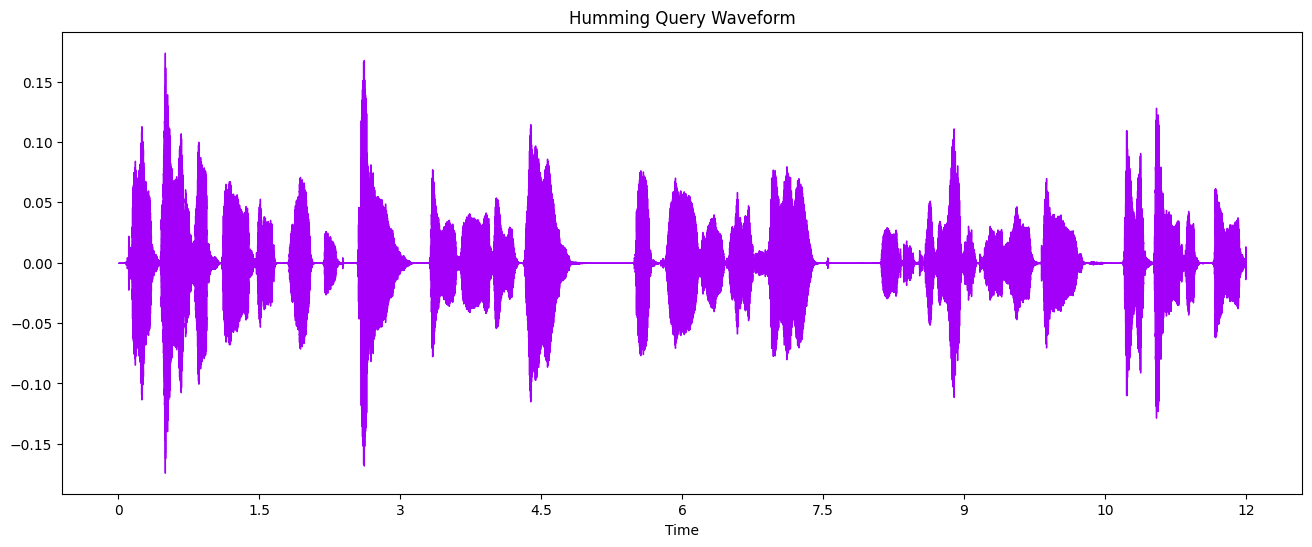

In [26]:
# Plot waveform of the query humming
y_query, sr_query = librosa.load(query_path, sr=None, mono=True)
plot_waveform(y_query, sr_query, title="Humming Query Waveform")

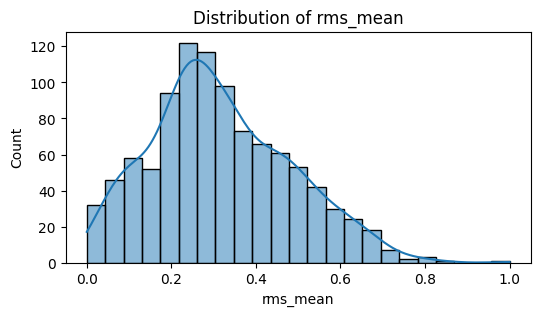

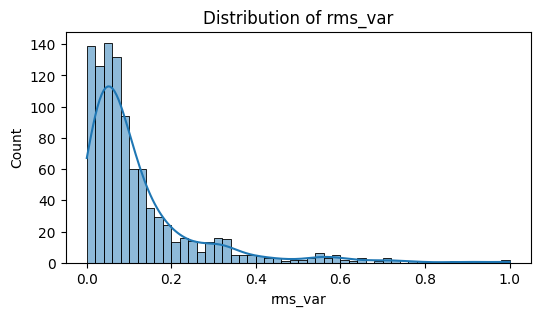

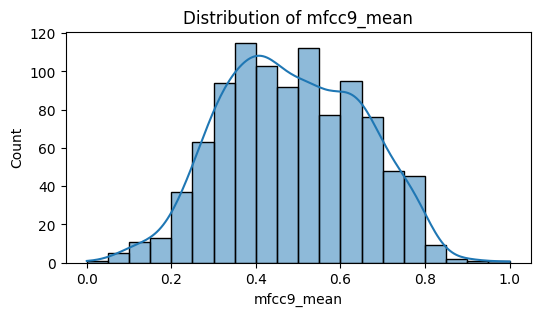

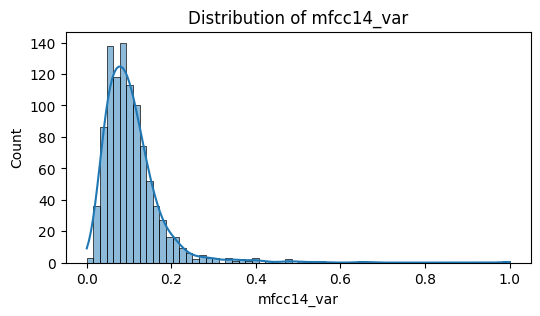

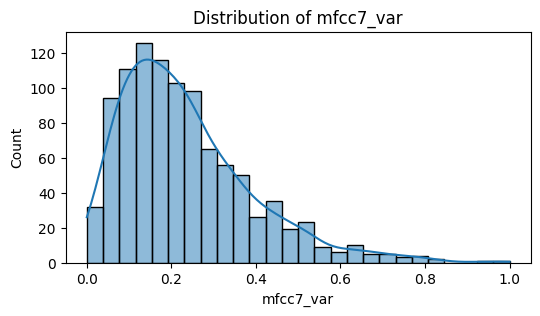

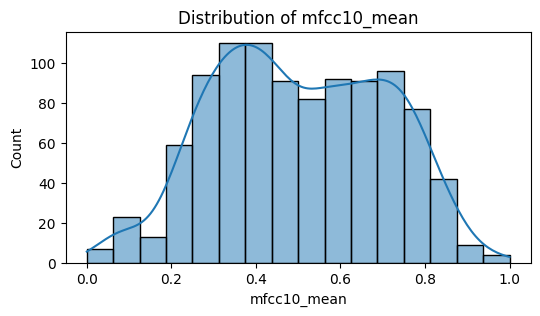

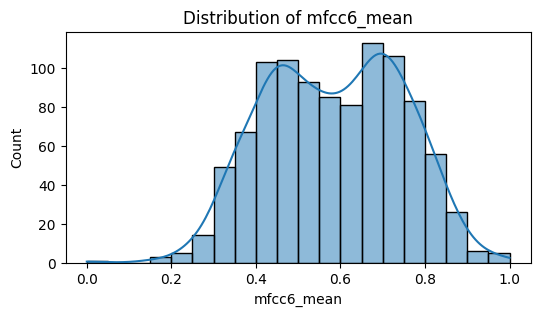

In [27]:
# Plot distribution of key features used in similarity
timbre_features = ['rms_mean', 'rms_var'] + [c for c in X_scaled.columns if c.startswith('mfcc')][:5]
plot_distribution(X_scaled, timbre_features)

### Understanding Distribution Plots

**Distribution plots** show how audio features are spread across all 1000 tracks. Each plot combines:
- **Histogram bars**: Count of tracks with values in each range (taller = more common)
- **KDE curve** (smooth line): Probability density showing the overall distribution shape

#### Features Explained

**`rms_mean`** - Average loudness/energy of the track
- Higher values → Louder, energetic tracks (metal, rock, hip-hop)
- Lower values → Quieter tracks (classical, jazz)

**`rms_var`** - How much loudness varies throughout the track
- Higher values → Dynamic tracks with loud/quiet sections (classical with crescendos)
- Lower values → Consistent, compressed audio (pop, electronic)

**`mfcc14_var`** - Variability in the 14th mel-frequency cepstral coefficient
- Captures temporal changes in mid-high frequency spectral features
- High variance indicates dynamic timbral changes (like changing instrumentation or effects)

**`mfcc6_mean`** - Average of the 6th MFCC
- Represents mid-range spectral shape characteristics
- Helps distinguish between different instrument types and vocal qualities

**`mfcc9_mean`** - Average of the 9th MFCC
- Captures higher-order spectral envelope details
- Useful for distinguishing subtle timbral differences between genres

**`mfcc22_mean`** - Average of the 22nd MFCC
- Represents very fine-grained spectral texture details
- Often captures noise characteristics and high-frequency content

**`mfcc8_var`** - Variability in the 8th MFCC
- Measures temporal fluctuations in mid-frequency spectral features
- High variance suggests more complex or varied timbral content

#### Distribution Shapes Tell Stories

**📊 Single peak (normal distribution)**: Feature varies gradually → good for continuous similarity
**📊 Two peaks (bimodal)**: Clear genre separation → excellent for classification
**📊 Long tail (skewed)**: Most tracks are similar, few are extreme → extremes identify specific genres
**📊 Flat/uniform**: Feature doesn't discriminate well → less useful for similarity

#### Why This Matters

- Features with **multiple peaks** often separate genres effectively
- **Wide spread** = diverse dataset, better for varied recommendations
- **Narrow peak** = all tracks similar on this feature
- Your query's position (near peak vs tail) indicates if it's typical or unusual

### Understanding A-Weighted Feature Space (UMAP)


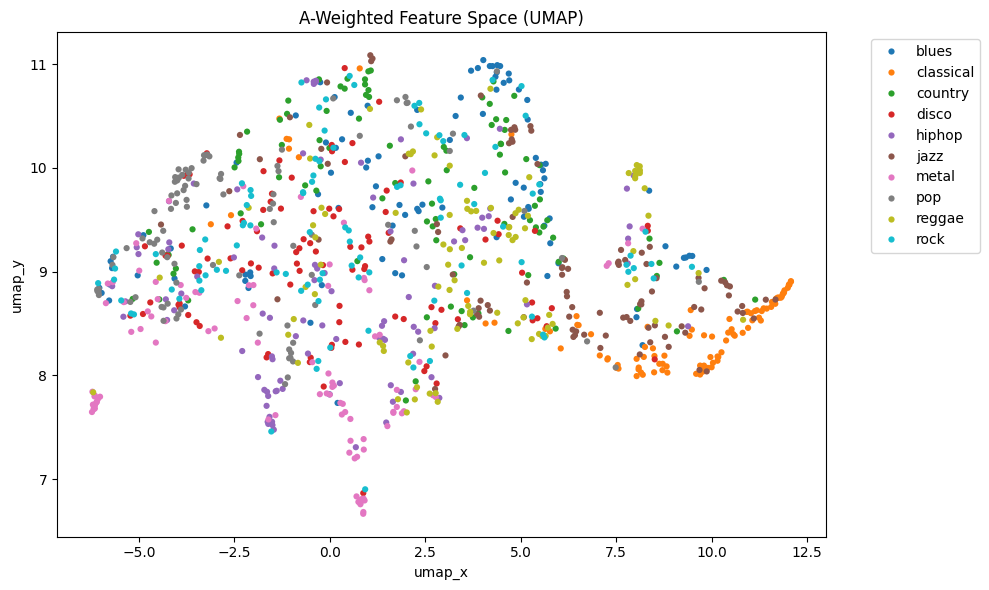

In [28]:
# Plot UMAP visualization for a-weighted group if available
if "a_weighted" in umap_results:
    plot_umap(umap_results["a_weighted"], "A-Weighted Feature Space (UMAP)")


**A-Weighted features** represent psychoacoustic properties—how loudness and frequency response affect human perception.

#### What's Being Plotted

Each dot represents one track in a 2D space created by UMAP (dimensionality reduction). Dots positioned close together have **similar A-weighted features**, meaning they sound perceptually similar in loudness and frequency balance to the human ear.

#### Key A-Weighted Properties

- **A-weighted mean**: Average loudness perception (accounting for frequency sensitivity)
- **A-weighted variance**: How much the loudness varies over time (dynamics)
- **A-weighted range**: Peak-to-minimum loudness difference

#### How to Interpret the Plot

- **Clusters**: Groups of same-colored dots = tracks of the same genre with similar perceived loudness characteristics
- **Spread**: Wide distribution = genre has diverse dynamic ranges
- **Separation**: Clear color boundaries = A-weighted features effectively distinguish genres
- **Outliers**: Isolated dots = unusual loudness profile for that genre (e.g., remastered track, live recording)

#### Why This Matters

A-weighted features capture what our ears actually perceive rather than raw frequency content. Rock tracks might cluster together due to heavy compression (consistent loudness), while classical might spread out (dynamic range). This layer helps find perceptually similar songs beyond just timbre or rhythm.

A-weighted features represent how music sounds to human ears by capturing psychoacoustic properties like loudness perception and frequency response. In the UMAP plot above, each dot represents one track positioned in 2D space where proximity indicates perceptual similarity in A-weighted characteristics. Tracks with similar colors (same genre) tend to cluster together when they share comparable loudness profiles and dynamics. The A-weighted mean reflects average loudness perception accounting for frequency sensitivity, while A-weighted variance reveals how much the loudness fluctuates throughout the track—for instance, rock often clusters tightly due to heavy compression resulting in consistent loudness, whereas classical music typically spreads across the plot due to its dynamic range. When you see clear color boundaries in the plot, it signals that A-weighted features effectively distinguish genres; conversely, outliers—isolated dots far from their genre cluster—indicate unusual loudness profiles such as remastered tracks or live recordings. This layer matters because it finds perceptually similar songs based on what our ears actually perceive rather than just timbre or rhythm alone, making recommendations feel more natural and coherent to listeners.

### Understanding Timbre Feature Space (UMAP)


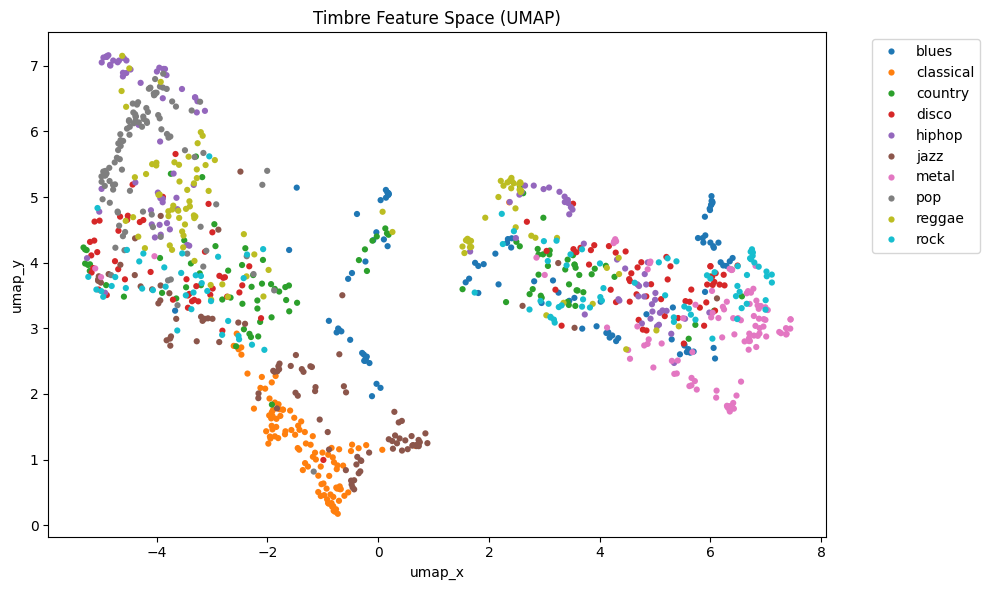

In [29]:
# Plot UMAP visualization for timbre group if available
if "timbre" in umap_results:
    plot_umap(umap_results["timbre"], "Timbre Feature Space (UMAP)")


**Timbre features** capture the unique tonal color and texture of sounds—the quality that distinguishes a trumpet from a violin playing the same note.

#### What's Being Plotted

Each dot represents one track in 2D space created by UMAP. Tracks positioned close together have **similar timbral characteristics**, meaning they share comparable instrument types, vocal qualities, and overall sonic texture.

#### Key Timbre Properties

- **MFCC coefficients**: Mel-frequency cepstral coefficients that capture spectral shape
- **Spectral centroid**: Where most audio energy is concentrated (bright vs dark sounds)
- **Zero crossing rate**: How much the waveform crosses zero (noise vs tonal content)
- **RMS energy**: Overall loudness and dynamics

#### How to Interpret the Plot

- **Clusters**: Same-colored dots = genres with similar timbral signatures (e.g., electric guitars in rock)
- **Spread**: Wide scatter = diverse instruments and production styles within a genre
- **Separation**: Clear color boundaries = timbral features distinguish genres well
- **Outliers**: Unusual dots = acoustic-heavy tracks in an electronic genre or vice versa

#### Why This Matters

Timbre is often what listeners recognize first—the "warm" feel of jazz, the "crisp" quality of pop, the "raw" edge of metal. This layer finds songs that share similar sonic character and instrumentation, helping create recommendations that feel stylistically cohesive regardless of rhythm or harmony.

Timbre features capture the unique tonal color and texture of sounds—the acoustic quality that lets you distinguish a trumpet from a piano even when they play the same note. In the UMAP plot above, each dot represents one track positioned in 2D space where proximity indicates similar timbral characteristics and sonic texture. Genres tend to cluster based on their characteristic instruments and production styles: rock tracks with electric guitars cluster together, classical with orchestral instruments clusters separately, and electronic music with synthesizers forms its own region. The timbre layer uses MFCC coefficients to measure spectral shape, spectral centroid to capture whether sounds are bright or dark, zero crossing rate to distinguish noise from tonal content, and RMS energy to reflect dynamics. When you see strong color separation in the plot, it signals that timbre effectively distinguishes genres; outliers might represent acoustic-heavy tracks in an electronic genre or highly produced classical pieces. This layer matters because timbre is often the first thing listeners recognize—the "warm" intimate quality of jazz, the "crisp engineered" sound of pop, or the "raw aggressive" edge of metal—making recommendations feel stylistically cohesive even when rhythmic or harmonic elements differ.

### Understanding Spectral Feature Space (UMAP)


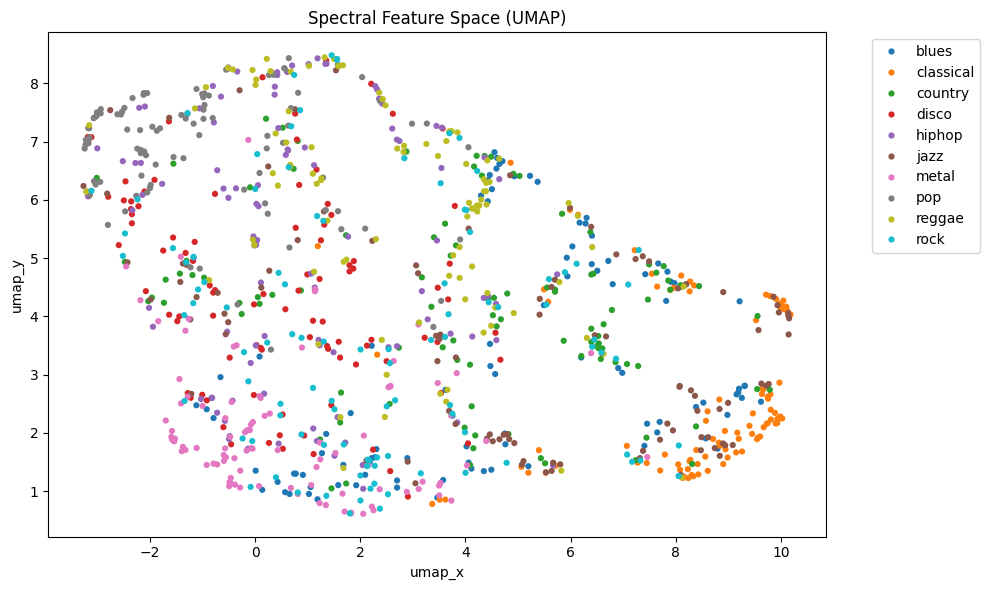

In [30]:
# Plot UMAP visualization for spectral group if available
if "spectral" in umap_results:
    plot_umap(umap_results["spectral"], "Spectral Feature Space (UMAP)")


**Spectral features** describe the frequency distribution and composition of sound—how energy is spread across the audio spectrum from low bass to high treble.

#### What's Being Plotted

Each dot represents one track in 2D space created by UMAP. Tracks positioned close together have **similar spectral characteristics**, meaning they share comparable frequency balance and energy distribution across the spectrum.

#### Key Spectral Properties

- **Spectral centroid**: The "center of mass" of the spectrum (bright/high vs dark/low frequency tracks)
- **Spectral rolloff**: Frequency below which 95% of energy is contained (brightness threshold)
- **Spectral bandwidth**: Spread of frequencies (narrow = pure tones, wide = complex/noisy)
- **Spectral flux**: How much the spectrum changes frame-to-frame (dynamic vs static)

#### How to Interpret the Plot

- **Clusters**: Same-colored dots = genres with similar frequency makeup (e.g., bass-heavy hip-hop vs treble-bright pop)
- **Spread**: Wide scatter = diverse frequency profiles within a genre
- **Separation**: Clear color boundaries = spectral features effectively distinguish genres
- **Outliers**: Unusual dots = atypical frequency profiles (e.g., acoustic stripped version in electronic genre)

#### Why This Matters

Spectral features reveal the fundamental frequency balance of music—whether it's bass-heavy (hip-hop, electronic), midrange-focused (vocals, guitars), or bright treble-dominant (cymbals, strings). This layer finds songs with compatible sonic frequency character, ensuring recommendations feel harmonically and texturally balanced.

Spectral features describe the frequency distribution and composition of sound—how audio energy spreads from deep bass to high treble—revealing the fundamental sonic character of each track. In the UMAP plot above, each dot represents one track positioned in 2D space where proximity indicates similar frequency balance and spectral makeup. Genres cluster based on their characteristic frequency profiles: hip-hop and electronic music with bass-heavy energy cluster together, classical and folk with rich midrange and bright upper frequencies cluster separately, and rock with mid-emphasis and dynamic range forms its own region. The spectral layer measures spectral centroid to identify the "brightness" of sound, spectral rolloff to find where 95% of energy sits, spectral bandwidth to capture whether sounds are pure and focused or complex and spread out, and spectral flux to detect how dynamically the spectrum changes. When you see strong color separation in the plot, it means spectral features effectively distinguish genres; outliers might represent an acoustic stripped-down version in a typically electronic genre or an unusually bright mix in a dark genre. This layer matters because frequency balance is critical to music compatibility—pairing bass-heavy tracks with treble-bright ones creates jarring transitions, while matching spectral character ensures smooth, cohesive playlist flow with consistent sonic balance.

### Understanding Chroma/Harmony Feature Space (UMAP)


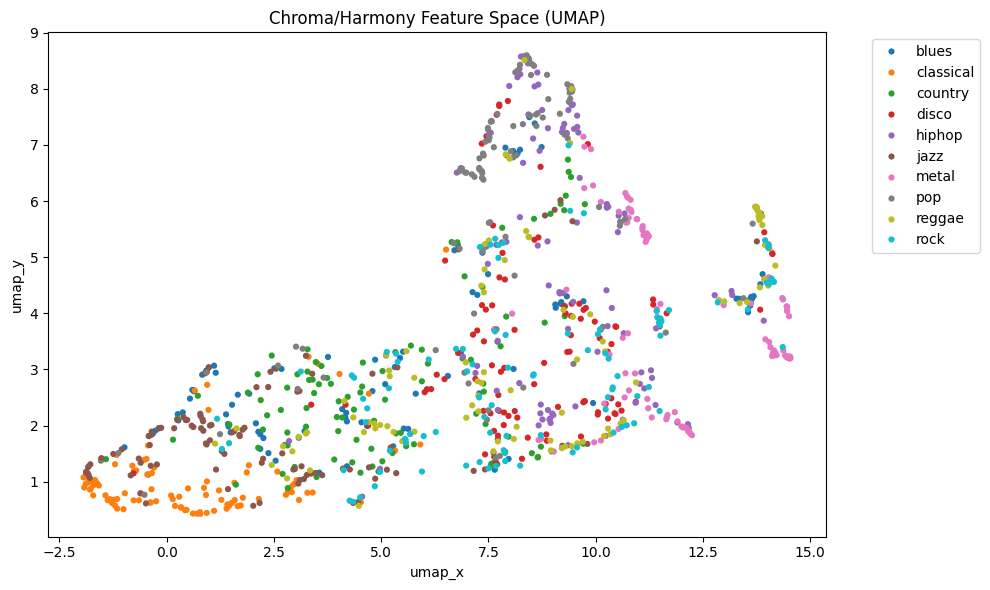

In [31]:
# Plot UMAP visualization for chroma/harmony group if available
if "chroma_harmony" in umap_results:
    plot_umap(umap_results["chroma_harmony"], "Chroma/Harmony Feature Space (UMAP)")



**Chroma/Harmony features** capture the pitch class and harmonic content of music—the chord progressions, key signatures, and melodic patterns that define musical identity.

#### What's Being Plotted

Each dot represents one track in 2D space created by UMAP. Tracks positioned close together have **similar harmonic characteristics**, meaning they share comparable chord structures, key centers, and harmonic complexity.

#### Key Chroma/Harmony Properties

- **Chroma features**: Distribution across 12 pitch classes (C, C#, D, D#, E, etc.)
- **Chroma variance**: How stable or shifting the harmonic content is
- **Constant-Q chromagram**: Fine-grained pitch information across frequencies
- **Harmonic centroid**: Average pitch distribution (bright keys vs dark keys)

#### How to Interpret the Plot

- **Clusters**: Same-colored dots = genres with similar harmonic signatures (e.g., blues with I-IV-V progressions)
- **Spread**: Wide scatter = diverse key signatures and chord progressions within a genre
- **Separation**: Clear color boundaries = harmonic features effectively distinguish genres
- **Outliers**: Unusual dots = atonal/modal pieces, key-heavy orchestral works, or experimental harmony

#### Why This Matters

Harmony is the emotional and structural foundation of music—major keys sound bright and happy, minor keys sound moody or dark, modal music sounds exotic. This layer finds songs with compatible harmonic language, ensuring recommendations flow with musical coherence and emotional consistency.

Chroma/harmony features capture the pitch class and harmonic content of music—the chord progressions, key signatures, and melodic patterns that define the emotional and structural foundation of each track. In the UMAP plot above, each dot represents one track positioned in 2D space where proximity indicates similar harmonic characteristics and pitch distribution. Genres cluster based on their harmonic DNA: blues and soul with dominant I-IV-V chord progressions cluster together, classical with complex modulation and varied harmonic movement clusters separately, and pop and rock with standard verse-chorus-bridge harmonic structures form their own regions. The chroma/harmony layer measures the distribution across 12 pitch classes to identify key signatures, chroma variance to capture harmonic stability or flux, constant-Q chromatograms for fine-grained pitch information, and harmonic centroid to determine overall pitch brightness. When you see strong color separation in the plot, it indicates that harmonic features effectively distinguish genres; outliers might represent atonal modern classical pieces in a tonal genre cluster or key-modulated compositions unusual for their category. This layer matters because harmony is music's emotional core—major keys sound bright and uplifting, minor keys evoke introspection or melancholy, modal music conveys exoticism or spirituality—and matching harmonic language ensures recommendations flow with musical and emotional coherence rather than jarring harmonic shifts.

### Understanding Rhythm/Tempo Feature Space (UMAP)


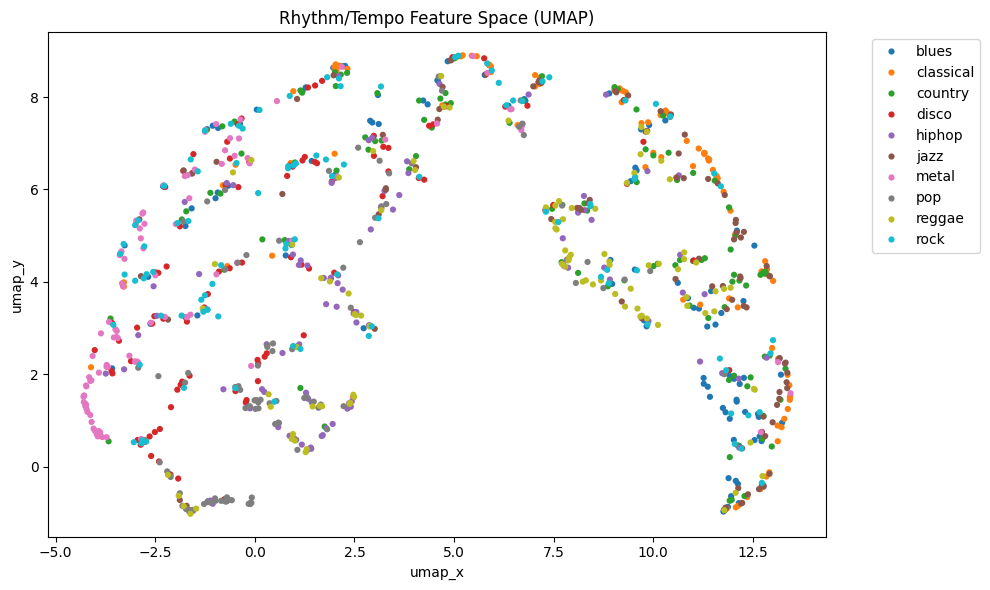

In [32]:
# Plot UMAP visualization for rhythm/tempo group if available
if "rhythm_tempo" in umap_results:
    plot_umap(umap_results["rhythm_tempo"], "Rhythm/Tempo Feature Space (UMAP)")


**Rhythm/Tempo features** capture the temporal characteristics of music—the beat, groove, and rhythmic patterns that drive the song's momentum and feel.

#### What's Being Plotted

Each dot represents one track in 2D space created by UMAP. Tracks positioned close together have **similar rhythmic characteristics**, meaning they share comparable tempos, beat structures, and groove patterns.

#### Key Rhythm/Tempo Properties

- **Tempo (BPM)**: Beats per minute—slow/ballad vs fast/uptempo
- **Onset strength**: How pronounced and clear the beat attacks are
- **Tempogram**: Temporal periodicity showing dominant rhythmic frequencies
- **Beat regularity**: How consistent the tempo is (metronomic vs rubato)

#### How to Interpret the Plot

- **Clusters**: Same-colored dots = genres with similar tempo ranges (e.g., fast hip-hop vs slower R&B)
- **Spread**: Wide scatter = diverse tempos and rhythmic approaches within a genre
- **Separation**: Clear color boundaries = rhythm effectively distinguishes genres
- **Outliers**: Unusual dots = unexpected tempos for a genre (ambient jazz in an upbeat pop cluster, for example)

#### Why This Matters

Rhythm and tempo are the physical pulse of music—they drive energy levels, danceability, and listener engagement. Slow songs feel meditative, fast songs feel energetic. This layer finds songs with compatible groove and momentum, ensuring smooth transitions and maintained listening energy.

## Results Summary

In [33]:
print(f"\n=== TRACK-BASED SIMILARITY ===")
print(f"Query track: {track_id}\n")
print(similarity_results)


=== TRACK-BASED SIMILARITY ===
Query track: metal00027

         track_id    genre  total_distance  layer1_distance  timbre_distance  \
681    metal00082    metal        1.662031         0.324764         0.976832   
671    metal00072    metal        1.718887         0.220869         0.903371   
986     rock00087     rock        1.743279         0.249365         0.801338   
205  country00005  country        1.753581         0.221060         0.909744   
768      pop00069      pop        1.778250         0.303252         0.943128   

     spectral_distance  rhythm_tempo_distance  chroma_harmony_distance  \
681           0.101657               0.097912                 0.160867   
671           0.080354               0.106788                 0.407504   
986           0.100115               0.002692                 0.589769   
205           0.246817               0.045197                 0.330763   
768           0.143085               0.109367                 0.279418   

     similarity  

In [ ]:
print(f"\n=== TIMBRE UMAP EMBEDDING ===")
print(umap_results["timbre"].head())


=== TIMBRE UMAP EMBEDDING ===
     umap_x    umap_y    track_id  genre
0  3.684651  2.995715  blues00000  blues
1  3.450837  3.419676  blues00002  blues
2  2.327514  4.302572  blues00001  blues
3  1.642823  3.757213  blues00003  blues
4  0.171197  4.252264  blues00004  blues


In [ ]:
print(f"\n=== ALL FEATURE GROUPS ===")
for group in umap_results.keys():
    print(f"\n{group.upper()}:")
    print(umap_results[group].head(3))


=== ALL FEATURE GROUPS ===

TIMBRE:
     umap_x    umap_y    track_id  genre
0  3.684651  2.995715  blues00000  blues
1  3.450837  3.419676  blues00002  blues
2  2.327514  4.302572  blues00001  blues

SPECTRAL:
     umap_x    umap_y    track_id  genre
0  4.759144  1.802882  blues00000  blues
1  7.401461  1.776433  blues00002  blues
2  4.424904  5.973190  blues00001  blues

RHYTHM_TEMPO:
      umap_x    umap_y    track_id  genre
0   8.898742  8.078344  blues00000  blues
1   9.900810  7.395130  blues00002  blues
2  11.566133  3.075504  blues00001  blues

CHROMA_HARMONY:
     umap_x    umap_y    track_id  genre
0  6.553768  2.885031  blues00000  blues
1  7.128965  4.377243  blues00002  blues
2  4.669533  1.994954  blues00001  blues

A_WEIGHTED:
     umap_x     umap_y    track_id  genre
0  0.123346  10.682468  blues00000  blues
1 -3.237058   9.638001  blues00002  blues
2  4.864933   9.855739  blues00001  blues
